# Data Extraction

## Librerie utili

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymongo import MongoClient

## Importo le secrets del progetto

In [ ]:
with open("secrets.json") as f:
    secrets = json.load(f)
    mongo_string = secrets["mongo_string"]

## Lettura, Analisi ed Estrazione dei dati da NOTEEVENTS.csv

### Data Analysis

In [2]:
# Set size and color for plots
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(10,6)}, 
    style="white"
)

In [3]:
df = pd.read_csv('NOTEEVENTS.csv', header=0)

C:\Users\giuse\AppData\Local\Temp\ipykernel_16544\2437473449.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NOTEEVENTS.csv', header=0)


In [4]:
# Calcola la lunghezza dei caratteri per ciascuna riga nella colonna "LEMMATIZED_TEXT"
df['TOKEN_COUNT'] = df['TEXT'].str.len() / 4

In [5]:
print(df.shape)
df.head(5)

(2083180, 12)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,TOKEN_COUNT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...,222.25
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...,3158.25
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...,2434.00
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,4284.50
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...,3624.75


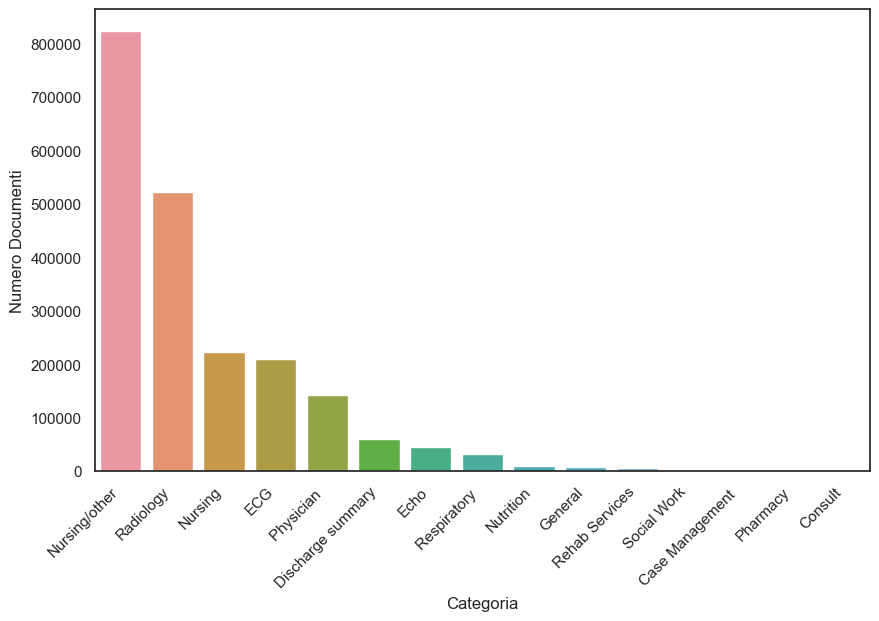

In [6]:
plot = sns.countplot(x=df['CATEGORY'], order=df['CATEGORY'].value_counts().index)
_ = plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Categoria')
plt.ylabel('Numero Documenti')
plt.show()

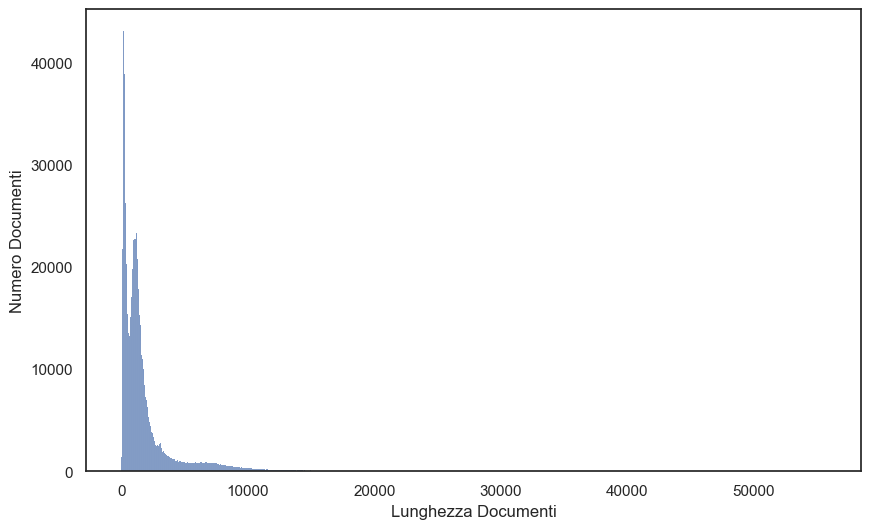

In [7]:
lns = [len(str(x)) for x in df['TEXT']]
sns.histplot(lns, kde=False)
plt.xlabel('Lunghezza Documenti')
plt.ylabel('Numero Documenti')
plt.show()

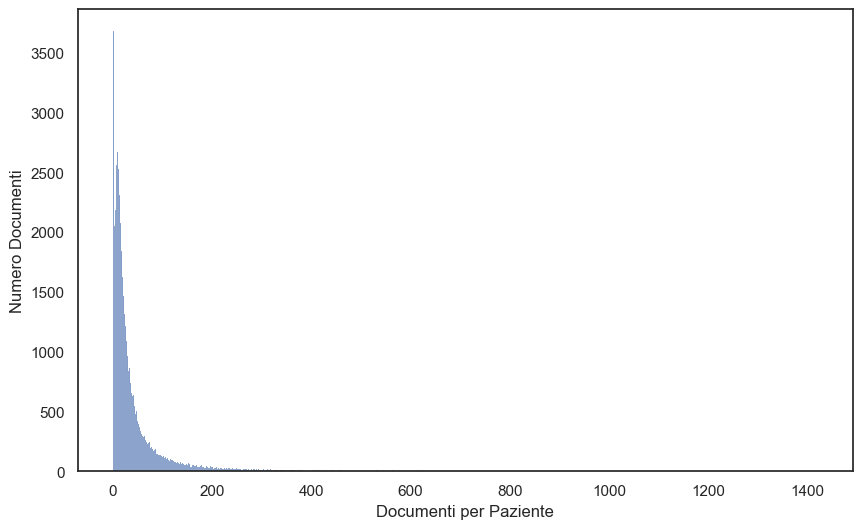

In [8]:
sns.histplot(df['SUBJECT_ID'].value_counts().values, kde=False)
plt.xlabel('Documenti per Paziente')
plt.ylabel('Numero Documenti')
plt.show()

### Extraction delle colonne scelte

In [9]:
filtered_df = df.drop('HADM_ID', axis=1)
filtered_df = filtered_df.drop('CHARTTIME', axis=1)
filtered_df = filtered_df.drop('STORETIME', axis=1)
filtered_df = filtered_df.drop('DESCRIPTION', axis=1)
filtered_df = filtered_df.drop('CGID', axis=1)
filtered_df = filtered_df[filtered_df['ISERROR'] != 1]
filtered_df = filtered_df[filtered_df['CATEGORY'] == "Discharge summary"]

In [10]:
filtered_df = filtered_df.drop('CATEGORY', axis=1)
filtered_df = filtered_df.drop('ISERROR', axis=1)

In [11]:
filtered_df['ROW_ID']=filtered_df['ROW_ID'].astype(int)
print(filtered_df.shape)
filtered_df.head(5)

(59652, 5)


,ROW_ID,SUBJECT_ID,CHARTDATE,TEXT,TOKEN_COUNT
0,174,22532,2151-08-04,Admission Date: [**2151-7-16**] Dischar...,222.25
1,175,13702,2118-06-14,Admission Date: [**2118-6-2**] Discharg...,3158.25
2,176,13702,2119-05-25,Admission Date: [**2119-5-4**] D...,2434.00
3,177,13702,2124-08-18,Admission Date: [**2124-7-21**] ...,4284.50
4,178,26880,2162-03-25,Admission Date: [**2162-3-3**] D...,3624.75


In [12]:
filtered_df = filtered_df.groupby('SUBJECT_ID').filter(lambda group: group['TOKEN_COUNT'].sum() <= 10000) 
filtered_df = filtered_df[filtered_df['TOKEN_COUNT'] >= 500]
filtered_df = filtered_df.groupby('SUBJECT_ID').filter(lambda x: len(x) > 1)

In [13]:
filtered_df.sort_values('TOKEN_COUNT').head(10)

,ROW_ID,SUBJECT_ID,CHARTDATE,TEXT,TOKEN_COUNT
57445,57361,19541,2143-02-26,"Name: [**Known lastname 497**] JR,[**Known fi...",500.00
58015,57862,27090,2120-04-30,"Name: [**Known lastname 12543**],[**Known fir...",500.25
59058,58758,71054,2166-08-08,"Name: [**Known lastname 4175**], [**Known fir...",500.75
55149,55828,5495,2138-12-20,"Name: [**Last Name (LF) 4668**], [**Known fir...",500.75
27170,19414,10763,2108-12-12,Admission Date: [**2108-12-2**] Dischar...,500.75
58465,58289,54623,2143-09-12,"Name: [**Known lastname 13799**],[**Known fir...",500.75
55102,56078,9137,2147-04-27,"Name: [**Known lastname **], [**Known firstna...",501.00
55101,56077,16552,2195-03-18,"Name: [**Known lastname 5786**], [**Known fir...",501.00
11201,9326,21321,2119-01-19,Admission Date: [**2119-1-4**] Discharge...,501.50
57731,58003,85986,2163-03-26,"Name: [**Known lastname **],[**Known firstnam...",501.75


In [14]:
filtered_df[filtered_df["TEXT"].str.startswith("Name")].head(10)

,ROW_ID,SUBJECT_ID,CHARTDATE,TEXT,TOKEN_COUNT
4990,4986,1422,2140-08-05,"Name: [**Known lastname **], [**Known firstna...",2114.50
4991,4987,1422,2140-08-05,"Name: [**Known lastname **], [**Known firstna...",2147.50
45578,52518,12009,2175-01-06,Name: [**Known lastname **] [**Known lastname...,894.50
50909,55417,48687,2170-01-03,"Name: [**Known lastname 2152**],[**Known firs...",840.00
50910,55418,26483,2160-04-04,"Name: [**Known lastname 1193**], [**Known fir...",915.25
50940,55203,5039,2130-12-08,"Name: [**Known lastname 299**], [**Known firs...",615.25
50941,55204,14787,2114-08-06,"Name: [**Known lastname 316**],[**Known first...",566.50
50942,55205,80986,2147-11-24,"Name: [**Known lastname 329**],[**Known first...",812.75
50946,55539,6713,2140-09-13,"Name: [**Known lastname 2862**], [**Known fir...",749.00
51037,55249,13867,2195-11-14,"Name: [**Known lastname 400**],[**Known first...",4585.75


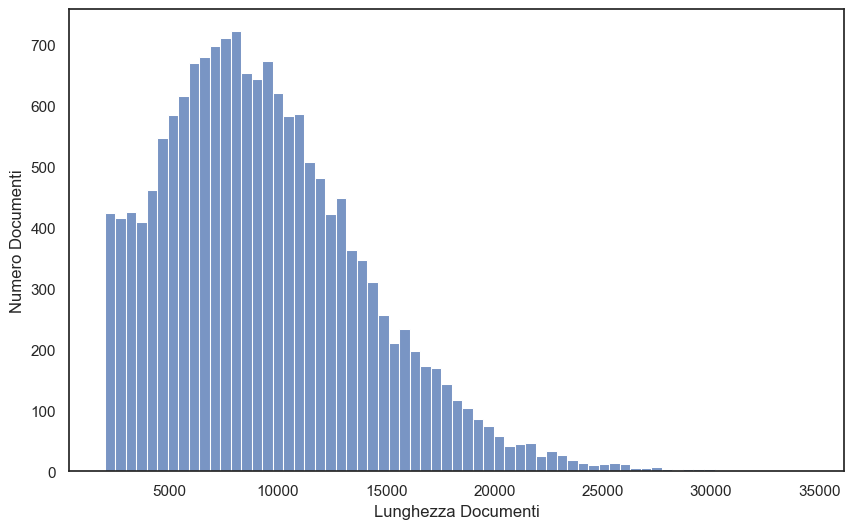

In [15]:
lns = [len(str(x)) for x in filtered_df['TEXT']]
sns.histplot(lns, kde=False)
plt.xlabel('Lunghezza Documenti')
plt.ylabel('Numero Documenti')
plt.show()

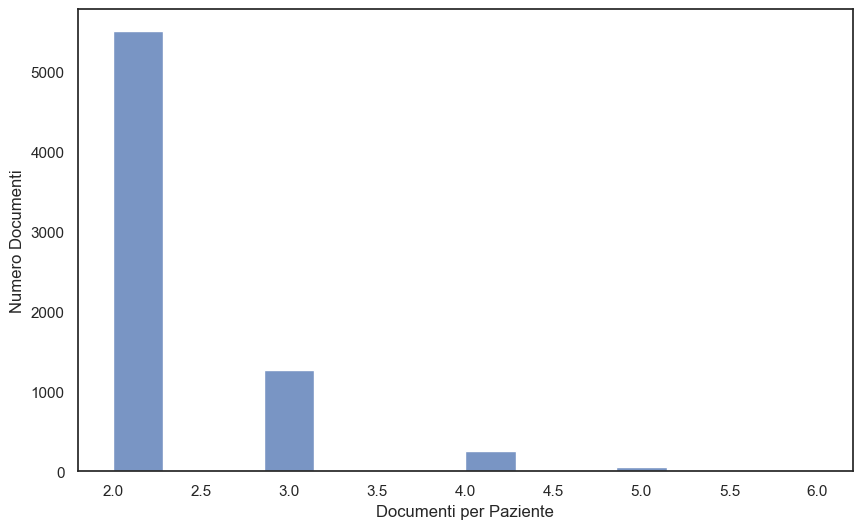

In [16]:
sns.histplot(filtered_df['SUBJECT_ID'].value_counts().values, kde=False)
plt.xlabel('Documenti per Paziente')
plt.ylabel('Numero Documenti')
plt.show()

In [17]:
filtered_df.nunique()

ROW_ID         16173
SUBJECT_ID      7094
CHARTDATE      12285
TEXT           16120
TOKEN_COUNT    10139
dtype: int64

In [18]:
filtered_df.drop_duplicates(subset='TEXT', inplace=True)
print(filtered_df.shape)
filtered_df.nunique()

(16120, 5)


ROW_ID         16120
SUBJECT_ID      7094
CHARTDATE      12285
TEXT           16120
TOKEN_COUNT    10139
dtype: int64

In [19]:
filtered_df = filtered_df.drop('TOKEN_COUNT', axis=1)

In [20]:
filtered_df

,ROW_ID,SUBJECT_ID,CHARTDATE,TEXT
1,175,13702,2118-06-14,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,2119-05-25,Admission Date: [**2119-5-4**] D...
3,177,13702,2124-08-18,Admission Date: [**2124-7-21**] ...
8,182,56174,2118-08-12,Admission Date: [**2118-8-10**] ...
9,183,56174,2118-12-09,Admission Date: [**2118-12-7**] ...
...,...,...,...,...
60203,59614,19405,2125-07-08,"Name: [**Known lastname 18335**], [**Known fi..."
60288,59647,67717,2201-07-03,"Name: [**Known lastname 5559**],[**Known firs..."
60388,59651,49879,2125-08-17,"Name: [**Known lastname 18448**],[**Known fir..."
60411,59608,93924,2104-06-14,"Name: [**Known lastname 18321**],[**Known fir..."


## Leggo il CSV dei pazienti

In [21]:
patient_df = pd.read_csv('PATIENTS.csv', header=0)

In [22]:
print(patient_df.shape)
patient_df.head(5)

(46520, 8)


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


### Seleziono solo le colonne d'interesse

In [23]:
patient_filtered_df = patient_df.drop('ROW_ID', axis=1)
patient_filtered_df = patient_filtered_df.drop('DOD_HOSP', axis=1)
patient_filtered_df = patient_filtered_df.drop('DOD_SSN', axis=1)

In [24]:
print(patient_filtered_df.shape)
patient_filtered_df.head(5)

(46520, 5)


,SUBJECT_ID,GENDER,DOB,DOD,EXPIRE_FLAG
0,249,F,2075-03-13 00:00:00,NaN,0
1,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,1
2,251,M,2090-03-15 00:00:00,NaN,0
3,252,M,2078-03-06 00:00:00,NaN,0
4,253,F,2089-11-26 00:00:00,NaN,0


## Unisco il NOTEEVENTS filtrato con i dati dei pazienti

In [26]:
total_df = pd.merge(filtered_df, patient_filtered_df, on='SUBJECT_ID', how='inner')

In [27]:
print(total_df.shape)
total_df.head(5)

(16120, 8)


,ROW_ID,SUBJECT_ID,CHARTDATE,TEXT,GENDER,DOB,DOD,EXPIRE_FLAG
0,175,13702,2118-06-14,Admission Date: [**2118-6-2**] Discharg...,F,2037-05-03 00:00:00,2126-10-06 00:00:00,1
1,176,13702,2119-05-25,Admission Date: [**2119-5-4**] D...,F,2037-05-03 00:00:00,2126-10-06 00:00:00,1
2,177,13702,2124-08-18,Admission Date: [**2124-7-21**] ...,F,2037-05-03 00:00:00,2126-10-06 00:00:00,1
3,182,56174,2118-08-12,Admission Date: [**2118-8-10**] ...,F,2073-12-25 00:00:00,NaN,0
4,183,56174,2118-12-09,Admission Date: [**2118-12-7**] ...,F,2073-12-25 00:00:00,NaN,0


## Creazione file NOTEEVENTS filtrato con i 'Discharge summary'

In [28]:
total_df.to_csv('filtered_noteevents.csv', index=False, sep=';')

## Connessione e caricamento su MongoDB

In [29]:
client = MongoClient(mongo_string)

db = client.noteevents
noteevents_db = db.noteevents_db

if list(noteevents_db.find({})) == []:
    docs = json.loads(total_df.to_json(orient='records'))
    noteevents_db.delete_many({})
    noteevents_db.insert_many(docs)

### Prova di connessione a MongoDB con esecuzione di una query

In [30]:
query = list(noteevents_db.aggregate([
    {"$match": {"SUBJECT_ID": 27431}},
    {"$project": {"_id": 0, "ROW_ID": 1, "SUBJECT_ID": 1, "TEXT": 1}}
]))

for document in query:
    print(document)

{'ROW_ID': 722, 'SUBJECT_ID': 27431, 'TEXT': "Admission Date:  [**2148-3-2**]              Discharge Date:   [**2148-3-7**]\n\nDate of Birth:  [**2070-10-4**]             Sex:   M\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**Last Name (NamePattern4) 290**]\nChief Complaint:\nHypotension/hypoxia\n\nMajor Surgical or Invasive Procedure:\nPlacement of Dobhoff tube\nPlacement of Arterial line\n\nHistory of Present Illness:\n77 yo M NH resident h/o schizophrenia, CAD, HTN, dementia p/w\nhypoxia and FTT from NH. According to the NH records, pt had an\nepisode of desaturation to mid 80's on RA several days ago. He\ncame up to 91% on 2L NC. He was also noted to have decreased po\nintake, eating only with assistance and only preferred foods.\nIVF fluids were given. CXR at NH neg, UA pos. Started on\nlevaquin 500 mg po on [**2-29**], also given 1 dose of CTX.\nSubsequently, ucx came back as < 10,000 organisms. As patient\ncontinued to